# Dynamic Rhythms of Power

Welcome to the <b> Dynamic Rhythms of Power</b> Challenge!
Are you ready to dive into the world of predictive analytics and make a real impact? Join us in the <i>Dynamic Rhythms of Power: Robust Prediction in Unpredictable Systems</i> challenge, where your data science skills will be put to the ultimate test!

In this thrilling competition, you'll be tasked with developing a cutting-edge model to predict power outages and their correlation with extreme, rare weather events like storms. Your mission: create a reliable system that can accurately forecast these outages, helping to enhance public safety, expedite power restoration, and reduce economic losses.

You'll have access to two primary datasets: a storm event dataset and a power outage dataset. These dual datasets will challenge you to develop a robust model that can adapt to various scenarios and provide precise forecasts. Feel free to explore and experiment with different algorithms, techniques, and models to achieve the best results.

But that's not all! In addition to the glory of having the top-performing model, you'll also have the chance to win prizes for honorable mentions. Will you rise to the challenge and become a top forecaster?

By participating, you'll contribute to advancing the state-of-the-art in rare event forecasting and power outage prediction, making our energy systems more sustainable, efficient, and resilient. So, gear up and get ready to make a difference!

### Supplied Materials:
 
*  Starter Notebook
*  Power Outage Dataset: This dataset includes `.csv` files detailing power outages at the county level across various states in the US, spanning from 2014 to 2023.
*  Storm Events Dataset: This dataset comprises `.csv` files with detailed information on storm events in the US, covering the period from 2014 to 2024.
*  `utils.py`: This module contains some functions used in this starter notebook and to help you get started.
*  `requirements.txt`: This file should contain all the required packages for your submission.

## Imports
REMEMBER TO ADD YOUR PACKAGES TO the requirements.txt

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, ccf
import numpy as np
import plotly.express as px
from datetime import datetime
import geopandas as gpd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

sys.path.append(os.path.abspath("../scripts"))  # Adjust the path
os.chdir(os.path.dirname(os.path.abspath("__file__")))  # Set working directory

from utils import *


## Data

You can download all the data from the challenge’s webpage or portal under the data tab.

### A. Power Outage dataset
Let's first take a look at the power outage dataset. Below, we first load the power outage for 2023, `eaglei_outages_2023.csv` as a pandas dataframe. It contains information on the total number of customers out of power for every 15 minutes that starts at `run_start_time`, for a given county in a given state. Note that not all time periods for all counties are available in the dataset. For more details about the dataset, please refer to the [research article](https://www.nature.com/articles/s41597-024-03095-5) that published this dataset.


In [2]:
# Load the dataset
df_power = pd.read_csv('../dynamic_rhythm_train_data/eaglei_data/eaglei_outages_2023.csv')
df_power

,fips_code,county,state,customers_out,run_start_time
0,1003,Baldwin,Alabama,1,2023-01-01 00:00:00
1,1011,Bullock,Alabama,9,2023-01-01 00:00:00
2,1015,Calhoun,Alabama,4,2023-01-01 00:00:00
3,1021,Chilton,Alabama,4,2023-01-01 00:00:00
4,1029,Cleburne,Alabama,142,2023-01-01 00:00:00
...,...,...,...,...,...
26101046,55095,Polk,Wisconsin,0,2023-12-31 23:45:00
26101047,55105,Rock,Wisconsin,1,2023-12-31 23:45:00
26101048,55109,St. Croix,Wisconsin,0,2023-12-31 23:45:00
26101049,55129,Washburn,Wisconsin,0,2023-12-31 23:45:00


Below, we plot the aggregated power outage for all the states in the US between a `start_time` and an `end_time` using the provided `plot_outages_on_map_us()` function. To calculate the values for this plot, the aggregated numbers are divided by \(24 x 4 = 96\) (96 15-minute periods in a day) to obtain the unit of `customers.day`. For details on how the final numbers for each state are calculated, please refer to the function.

For example, if a state has a value of 100k customers.day in a given period, it means that, on average, 100k customers were without power for one day. This is also equivalent to, for instance, 50k customers being without power for two days. In the example below, three states of Michigan, California and Texas have the largest power outages during Jan and Feb of 2023.


**Note:** The function below uses the `plotly` library to plot the figure. Plotly figures may not display correctly in VS Code or other IDEs due to differences in rendering compared to Jupyter Lab. If you are running this code in an IDE other than Jupyter Notebook, ensure that the Plotly rendering is set up correctly. For example, in VS Code, you can add the following lines to your script and make sure the Jupyter and Python extensions are installed and up-to-date:

```python
import plotly.io as pio
pio.renderers.default = 'vscode'  # or 'notebook'
```

In [3]:
plot_outages_on_map_us(start_time = '2023-01-01 00:00:00',
                       end_time='2023-02-28 00:00:00',
                       )

In [4]:
# start_time = '2021-02-11 00:00:00'
# end_time='2021-02-20 00:00:00'
# plot_outages_on_map_state(start_time,
#                           end_time,
#                           state='Texas',
#                           )

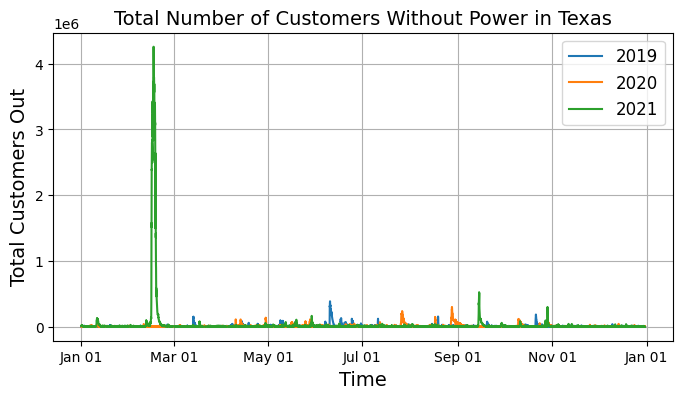

In [5]:
state = 'Texas'
years = ['2019', '2020', '2021']
plot_outages_ts_years(state, years)

As another example, we use the function plot_outages_ts_states() to plot the time history of the total number of customers without power in Michigan, California, and Florida for 2021. The plot reveals outage spikes in California in late January, primarily due to severe winter storms that brought heavy rain, snow, and strong winds. These storms caused widespread damage to power lines and infrastructure, leading to outages affecting hundreds of thousands of customers.

An even larger power outage occurred in Michigan in August 2021. Severe storms swept through the state, causing extensive damage and power outages. At the peak, nearly one million households were without power. The high winds from these storms knocked down trees and power lines, leading to significant disruptions.

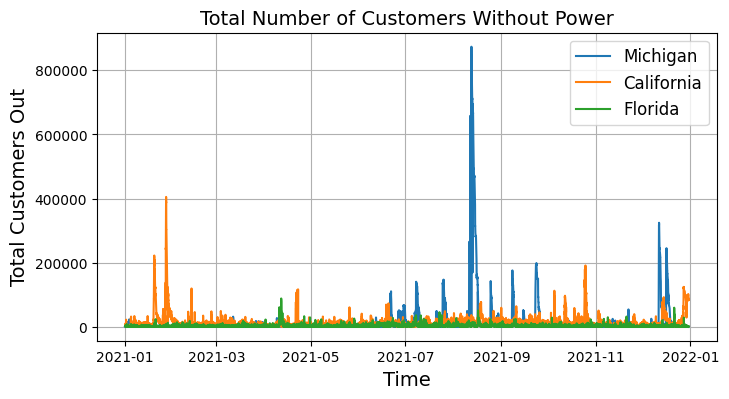

In [6]:
start_time = '2021-02-12 00:00:00'
end_time='2021-02-20 00:00:00'
states = ['Michigan', 'California', 'Florida']
plot_outages_ts_states(start_time,
                       end_time,
                       states,
                    #    data_directory = './data/eaglei_data'
                       )

### B.  NOAA's Storm Events Dataset


Next, we will explore the provided storm event dataset from the National Oceanic and Atmospheric Administration (NOAA). We have included storm event details for the U.S. from 2014 to 2024, with one `.csv` file for each year. These files are directly downloaded from NOAA's storm events public database. For convenience, we have also combined these 11 files into a single `StormEvents_2014_2024.csv` file for use in this starter notebook.

**Important Note:** NOAA's storm events dataset is public, and you can download additional datasets for longer periods. We encourage you to do so to build more robust and accurate predictive models. Additionally, NOAA's database is just one of many public datasets on storm events. We encourage you to explore other **public** datasets on storm events, power outages, meteorological weather data, and any other data you find useful for predicting storm events and power outages.


Below, we load `StormEvents_2014_2024.csv` as a pandas DataFrame. This DataFrame provides extensive details about storm events, including their type, location, time, and magnitude. For example, you can view all 55 types of storms in the U.S. from 2014 to 2024 by examining the `EVENT_TYPE` column, as shown below.

In [7]:
df_events = pd.read_csv("../dynamic_rhythm_train_data//NOAA_StormEvents/StormEvents_2014_2024.csv")
df_events

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,201402,18,1000,201402,18,2000,83473,503953,NEW HAMPSHIRE,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure developing south of Long Island a...,Eight to twelve inches of snow fell across eas...,CSV
1,201403,30,831,201403,30,931,83971,507163,MASSACHUSETTS,25,...,1.0,WNW,CHELMSFORD CENTER,42.5861,-71.3472,42.5867,-71.3469,A stacked low pressure system passed south and...,Boston Road was closed near Brian Road due to ...,CSV
2,201404,27,2306,201404,27,2306,83517,506236,MISSOURI,29,...,1.0,W,AVA,36.9500,-92.6600,36.9500,-92.6600,A powerful storm system and a dry line produce...,NaN,CSV
3,201404,27,2303,201404,27,2303,83517,506237,MISSOURI,29,...,1.0,W,AVA,36.9500,-92.6600,36.9500,-92.6600,A powerful storm system and a dry line produce...,Several power poles snapped and trees blown down.,CSV
4,201402,15,1300,201402,15,2100,83132,501499,WASHINGTON,53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A strong cold front produced strong winds for ...,Two stations measured strong wind gusts in the...,CSV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691429,202405,26,1148,202405,26,1148,192532,1188957,KENTUCKY,21,...,1.0,E,EAST NEEDMORE,37.6500,-84.7200,37.6500,-84.7200,A strong storm system moved across the Ohio an...,A trained spotter estimated 60 mph wind gusts ...,CSV
691430,202405,22,1809,202405,22,1809,192530,1188234,INDIANA,18,...,2.0,ESE,SCOTTSBURG,38.6713,-85.7364,38.6713,-85.7364,A cold front moved into the Ohio Valley during...,A tree was down at Lovers Lane and Prewitt Lane.,CSV
691431,202405,22,1757,202405,22,1757,192530,1188232,INDIANA,18,...,2.0,NE,CANNELTON,37.9478,-86.7247,37.9478,-86.7247,A cold front moved into the Ohio Valley during...,A tree was reported down over Chestnut Grove R...,CSV
691432,202406,23,1745,202406,23,1750,191388,1192879,NEW HAMPSHIRE,33,...,1.0,NE,GREENLAND,43.0400,-70.8400,43.0400,-70.8400,A supercell thunderstorm developed across sout...,A supercell thunderstorm dropped hail the size...,CSV


In [8]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691434 entries, 0 to 691433
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   BEGIN_YEARMONTH     691434 non-null  int64  
 1   BEGIN_DAY           691434 non-null  int64  
 2   BEGIN_TIME          691434 non-null  int64  
 3   END_YEARMONTH       691434 non-null  int64  
 4   END_DAY             691434 non-null  int64  
 5   END_TIME            691434 non-null  int64  
 6   EPISODE_ID          691434 non-null  int64  
 7   EVENT_ID            691434 non-null  int64  
 8   STATE               691434 non-null  object 
 9   STATE_FIPS          691434 non-null  int64  
 10  YEAR                691434 non-null  int64  
 11  MONTH_NAME          691434 non-null  object 
 12  EVENT_TYPE          691434 non-null  object 
 13  CZ_TYPE             691434 non-null  object 
 14  CZ_FIPS             691434 non-null  int64  
 15  CZ_NAME             691434 non-nul

In [9]:
print("Different storm event types in the US from 2014 to 2024:")
df_events['EVENT_TYPE'].unique()

Different storm event types in the US from 2014 to 2024:


array(['Heavy Snow', 'Flood', 'Hail', 'Thunderstorm Wind', 'High Wind',
       'Winter Storm', 'Winter Weather', 'Drought', 'Ice Storm',
       'Tornado', 'Strong Wind', 'Flash Flood', 'Extreme Cold/Wind Chill',
       'Blizzard', 'Avalanche', 'Marine Thunderstorm Wind',
       'Cold/Wind Chill', 'Funnel Cloud', 'Heavy Rain', 'Frost/Freeze',
       'Wildfire', 'Sleet', 'Dust Storm', 'Freezing Fog', 'Waterspout',
       'Rip Current', 'Marine Hail', 'Lightning', 'Debris Flow',
       'Dense Fog', 'Astronomical Low Tide', 'High Surf', 'Coastal Flood',
       'Dust Devil', 'Hurricane (Typhoon)', 'Lake-Effect Snow',
       'Marine Strong Wind', 'Marine High Wind', 'Heat', 'Tropical Storm',
       'Lakeshore Flood', 'Seiche', 'Excessive Heat', 'Dense Smoke',
       'Marine Lightning', 'Marine Tropical Storm', 'Storm Surge/Tide',
       'Sneakerwave', 'Tsunami', 'Tropical Depression',
       'Marine Dense Fog', 'Hurricane', 'Marine Hurricane/Typhoon',
       'Marine Tropical Depression', 'Vo

<br>

**Storm events type and counts/frequency:** One of the key features of storm events that impact power systems is the type of storm and the frequency with which it occurs within a county or state. The number of occurrences in a county/state in a short time period, can serve as an indicator of the event's severity and its extent. Below, we use the function `barchart_events_by_state()` to illustrate the distribution of event counts for three types of storms: winter storms, hurricanes, and excessive heat, specifically for the state of Texas.

First, we visualize the aggregated data from 2014 to 2024, and then we focus on the year 2021. The bar chart reveals that approximately half of the winter storms in February from 2014 to 2024 occurred in 2021. This corresponds to the **Great Texas Freeze**, a significant event that led to widespread power outages and affected many residents.

By analyzing the distribution of storm events, we can gain insights into patterns and trends that are crucial for understanding the impact on power systems. The frequency and type of storm events, along with their severity and duration, are important factors to consider when assessing the resilience of power infrastructure and planning for future events. Next we explore the severity and duration of storms.


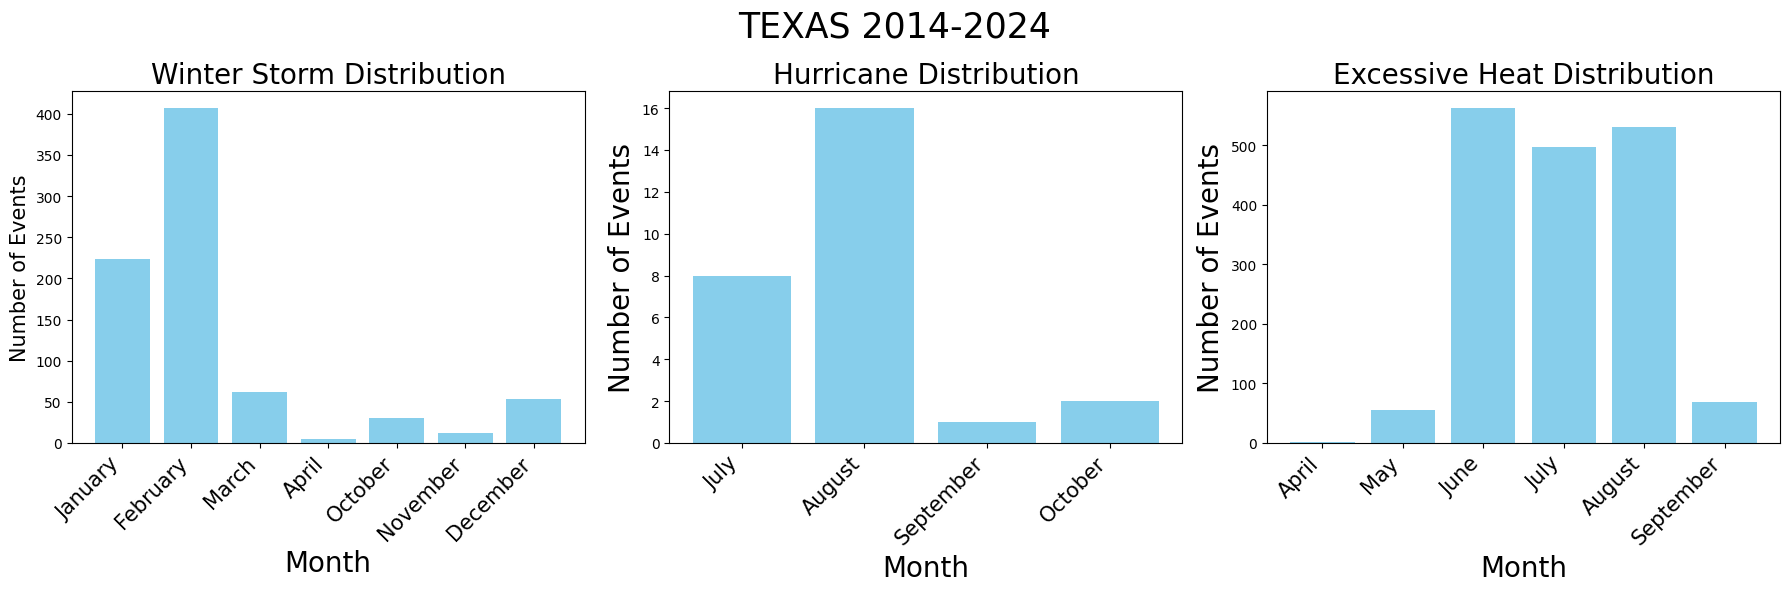

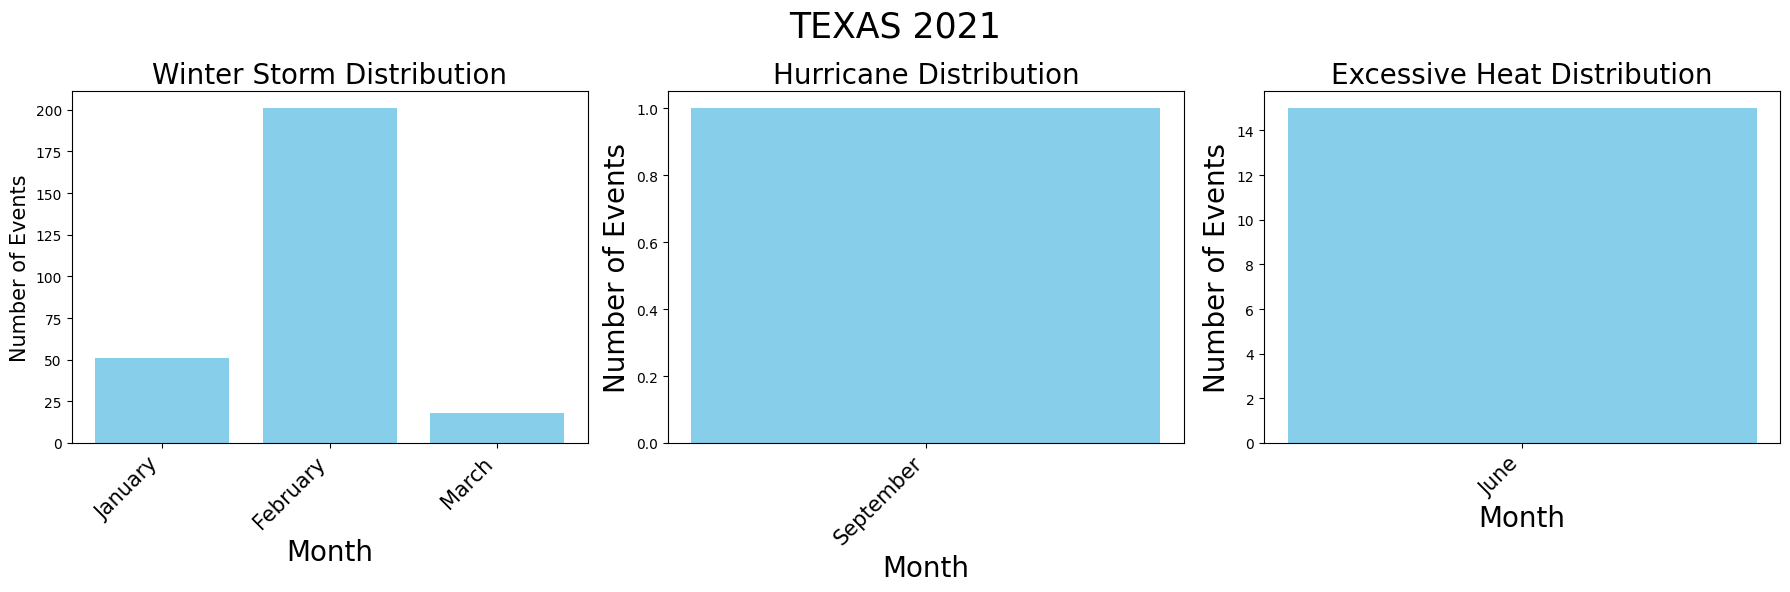

In [10]:
TX_event_types = ['Winter Storm', 'Hurricane', 'Excessive Heat']

barchart_events_by_state(df = df_events, state='TEXAS', event_types=TX_event_types)

barchart_events_by_state(df = df_events, state='TEXAS', event_types=TX_event_types, all_years=False, which_year=2021)

<br>

**Storm events severity and duration:** To understand the effects of storm events on power outages, it's crucial to consider not only the type of storm event but also its severity and duration. Below, we first create a new column in our DataFrame to represent the duration of storm events in hours. We then plot a histogram of event durations for all storm events aggregated across the entire U.S. from 2014 to 2024.

The histogram reveals that event durations are highly skewed, with many events having short durations. These short-duration events are likely inconsequential to power outages. However, it's important to note that depending on the type of storm event, even short-duration events can have a significant impact on power outages.

To further analyze this, we plot the event durations individually for each storm event type using a box plot. This visualization helps us understand the distribution of event durations for different types of storms and highlights the variability in their impact on power systems.

In summary, when assessing the impact of storm events on power outages, it's essential to consider not just the frequency of events but also their type, severity, and duration. These factors are critical in understanding and predicting the potential disruptions to power systems.

In [11]:
df_events['BEGIN_DATE'] = pd.to_datetime(
    df_events['BEGIN_YEARMONTH'].astype(str) + df_events['BEGIN_DAY'].astype(str).str.zfill(2),
    format='%Y%m%d'
)

df_events['BEGIN_DATETIME'] = pd.to_datetime(
    df_events['BEGIN_YEARMONTH'].astype(str) + df_events['BEGIN_DAY'].astype(str).str.zfill(2) + df_events['BEGIN_TIME'].astype(str).str.zfill(4),
    format='%Y%m%d%H%M'
)

df_events['END_DATE'] = pd.to_datetime(
    df_events['END_YEARMONTH'].astype(str) + df_events['END_DAY'].astype(str).str.zfill(2),
    format='%Y%m%d'
)

df_events['END_DATETIME'] = pd.to_datetime(
    df_events['END_YEARMONTH'].astype(str) + df_events['END_DAY'].astype(str).str.zfill(2) + df_events['END_TIME'].astype(str).str.zfill(4),
    format='%Y%m%d%H%M'
)

# Calculate duration in hours
df_events['DURATION_HOURS'] = (df_events['END_DATETIME'] - df_events['BEGIN_DATETIME']).dt.total_seconds() / 3600


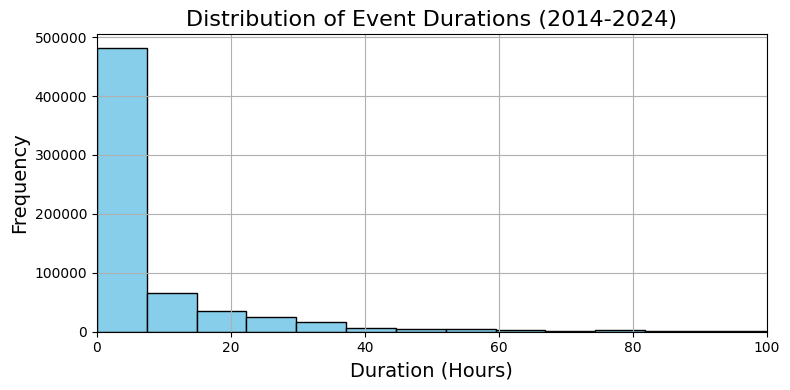

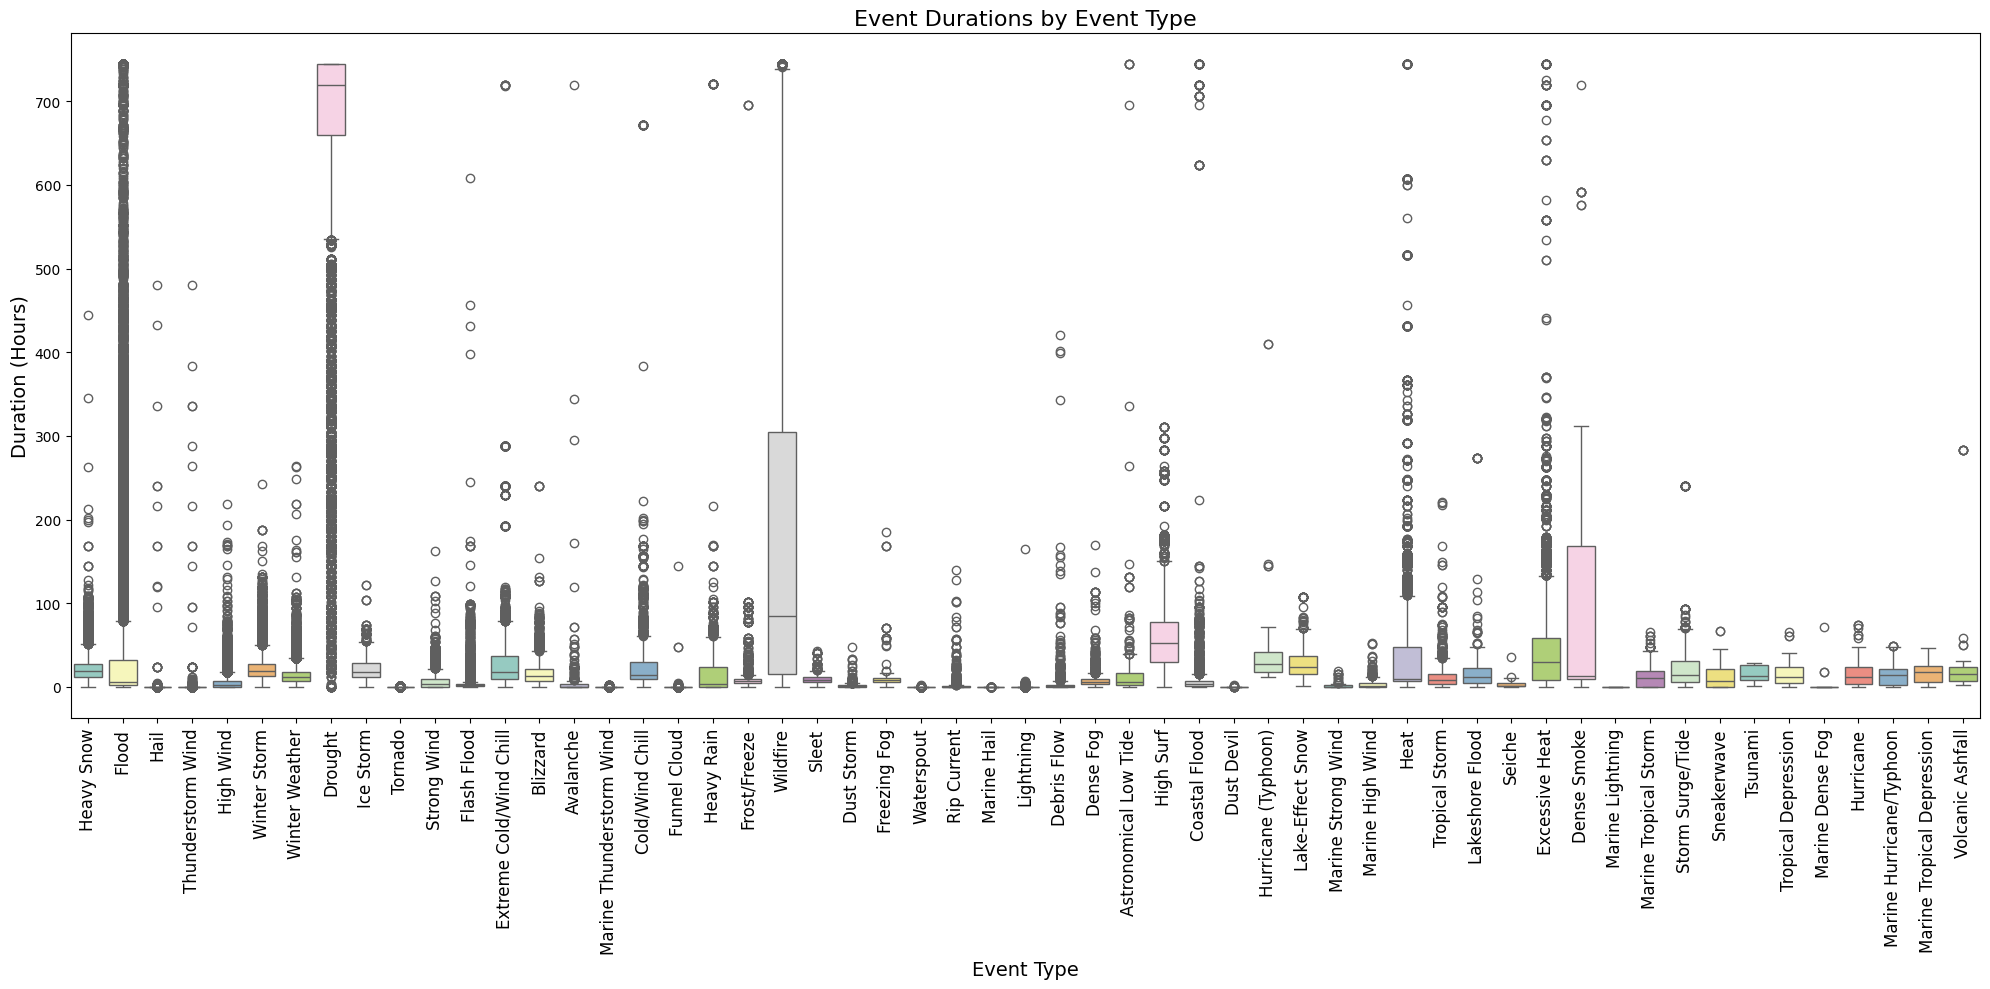

In [12]:
# Plot histogram for DURATION_HOURS
plt.figure(figsize=(8, 4))
plt.hist(df_events['DURATION_HOURS'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Event Durations (2014-2024)', fontsize=16)
plt.xlabel('Duration (Hours)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, 100)  # Adjust limit to focus on long-duration events
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot boxplot for DURATION_HOURS for every storm event
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_events, x='EVENT_TYPE', y='DURATION_HOURS', showfliers=True, palette="Set3")
plt.title('Event Durations by Event Type', fontsize=16)
plt.xlabel('Event Type', fontsize=14)
plt.ylabel('Duration (Hours)', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

## Combined Datasets: Basic Correlation Analysis

So far, we have briefly discussed the two datasets and highlighted the importance of extreme weather events on power outages. In this section, we will examine this correlation more rigorously.

We begin by creating a compatible and combined dataframe using both the power outage and storm event datasets. This is achieved using the provided function `combine_agg_ts()`. For a given state and time range, this function generates two dataframes: one with hourly increments and the other with daily increments of the number of customers without power, along with event counts for all storm event types in that state. With these hourly and daily time series of affected customers and event counts, we can perform some basic statistical analyses.

To illustrate this process, we start by creating these dataframes for the state of Texas, covering the period from 2019 to the end of 2021. Next, we calculate the correlations between the number of affected customers (`customers_out`) and all other variables, i.e., event counts for all storm event types in the state. We then plot the correlations that have a value greater than 0.1.

The results are significantly influenced by the Great Texas Freeze of 2021, a historic winter storm that caused widespread power outages. The storm types with notable correlations include Winter Storm, Cold/Wind Chill, Frost/Freeze, Ice Storm, and Extreme Cold/Wind Chill. These findings underscore the critical impact of severe weather events on power infrastructure and highlight the importance of understanding these correlations for better preparedness and response strategies.


In [13]:
state = 'Texas'
start_year = 2014
start_month = 1
start_day = 1
end_year = 2023
end_month = 12
end_day = 30
df_TX_ts_comb_hr, df_TX_ts_comb_day = combine_agg_ts(state = state,
                                                     start_year = start_year,
                                                     start_month = start_month,
                                                     start_day = start_day,
                                                     end_year = end_year,
                                                     end_month = end_month,
                                                     end_day = end_day,
                                                     data_directory_power = '../dynamic_rhythm_train_data/eaglei_data',
                                                     data_directory_events = '../dynamic_rhythm_train_data/NOAA_StormEvents')

In [15]:
# df_TX_ts_comb_day['event_count Drought'].describe()
df_TX_ts_comb_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3347 entries, 2014-11-01 to 2023-12-30
Freq: D
Data columns (total 39 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   event_count Thunderstorm Wind        3347 non-null   float64
 1   event_count Hail                     3347 non-null   float64
 2   event_count Drought                  3347 non-null   float64
 3   event_count Winter Weather           3347 non-null   float64
 4   event_count High Wind                3347 non-null   float64
 5   event_count Winter Storm             3347 non-null   float64
 6   event_count Dust Storm               3347 non-null   float64
 7   event_count Cold/Wind Chill          3347 non-null   float64
 8   event_count Freezing Fog             3347 non-null   float64
 9   event_count Rip Current              3347 non-null   float64
 10  event_count Strong Wind              3347 non-null   float64
 11  even

In [26]:
df_TX_ts_comb_hr.describe().T

,count,mean,std,min,25%,50%,75%,max
event_count Thunderstorm Wind,80324.0,0.027840,0.200133,0.0,0.00,0.0,0.0000,8.75
event_count Hail,80324.0,0.044912,0.286972,0.0,0.00,0.0,0.0000,11.00
event_count Drought,80324.0,46.231522,51.479831,0.0,0.00,33.0,72.3750,289.25
event_count Winter Weather,80324.0,0.228135,2.103618,0.0,0.00,0.0,0.0000,51.75
event_count High Wind,80324.0,0.135237,1.211028,0.0,0.00,0.0,0.0000,64.00
event_count Winter Storm,80324.0,0.276318,4.010150,0.0,0.00,0.0,0.0000,146.00
event_count Dust Storm,80324.0,0.000843,0.080789,0.0,0.00,0.0,0.0000,15.75
event_count Cold/Wind Chill,80324.0,0.115165,2.265493,0.0,0.00,0.0,0.0000,88.75
event_count Freezing Fog,80324.0,0.000131,0.011296,0.0,0.00,0.0,0.0000,1.00
event_count Rip Current,80324.0,0.000156,0.007483,0.0,0.00,0.0,0.0000,0.75


In [18]:

# df_TX_ts_comb_hr.info()
# df_TX_ts_comb_day.info()
df_TX_ts_comb_day['customers_out'].unique()

array([1582.2875    ,  830.73913043, 1660.40625   , ..., 1254.65625   ,
       1978.85416667, 1690.19791667])

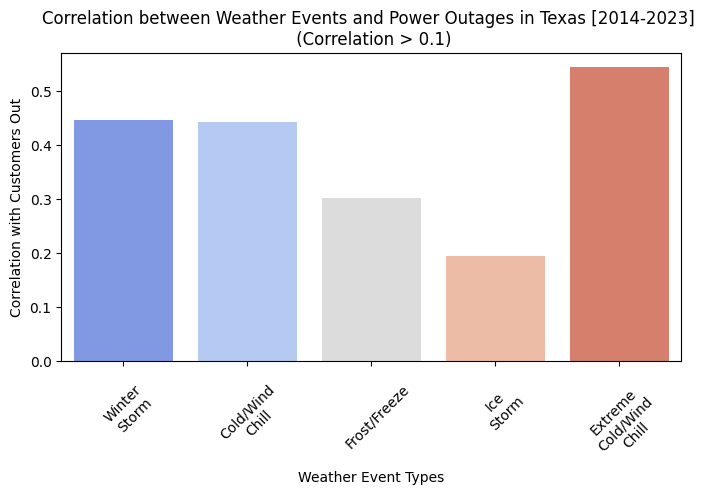

In [ ]:
correlation_with_customers_out = df_TX_ts_comb_hr.corr()['customers_out'].drop('customers_out')

# Filter correlations higher than 0.1
filtered_correlation = correlation_with_customers_out[correlation_with_customers_out > 0.1]

corr_list = list(filtered_correlation.index)

# Remove 'event_count' from the column names for plotting
filtered_correlation.index = filtered_correlation.index.str.replace('event_count', '')

# Split two-word names into two lines
filtered_correlation.index = filtered_correlation.index.str.replace(' ', '\n')

# Plot the filtered correlation
plt.figure(figsize=(8, 4))
sns.barplot(x=filtered_correlation.index, y=filtered_correlation.values,
            hue=filtered_correlation.index, palette='coolwarm')
plt.xlabel('Weather Event Types')
plt.ylabel('Correlation with Customers Out')
plt.title('Correlation between Weather Events and Power Outages in Texas [2014-2023] \n (Correlation > 0.1)')
plt.xticks(rotation=45)
plt.show()


To visually examine these correlations, we plot the time histories of power outages (`customers_out`) and event counts for the five event types mentioned earlier (Winter Storm, Cold/Wind Chill, Frost/Freeze, Ice Storm, and Extreme Cold/Wind Chill) for February 2021. The figure supports the correlation analysis discussed above. 

An interesting observation is that power outages lag behind storm events by a few days. This makes sense, as the buildup of a storm can eventually damage power infrastructure and cause outages. To further investigate this time delay between power outages and storm events, we calculate their correlation at different time shifts using the cross-correlation function (`ccf`) from the `statsmodels` library. 

We focus specifically on the power outage and Winter Storm time series. For this analysis, we use the combined dataset with daily increments rather than hourly increments. This choice is based on our visual inspection, which suggests that the lag between these two time series is roughly three days. The results of the `ccf` analysis confirm this observation, showing that the correlation values drop significantly after 3-4 days (shifts).

By understanding this time delay, we can better predict the impact of storm events on power outages and improve our preparedness and response strategies. This analysis highlights the importance of considering time lags in correlation studies, as they can provide valuable insights into the dynamics between extreme weather events and power system disruptions.



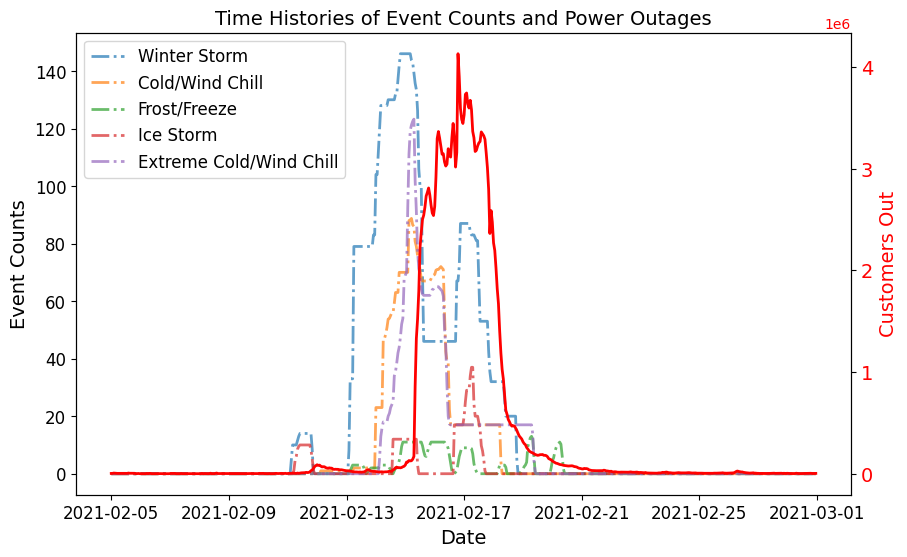

In [ ]:
plot_ts_events_power(df = df_TX_ts_comb_hr,
                     event_types = corr_list,
                     start_year = 2021,
                     start_month = 2,
                     start_day = 5,
                     end_year = 2021,
                     end_month = 2,
                     end_day = 28)

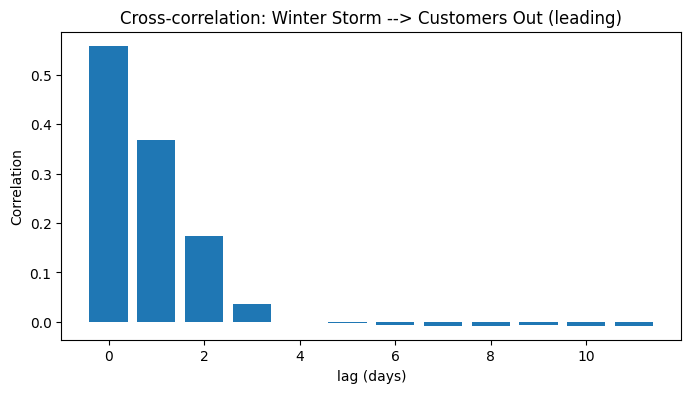

In [ ]:
power_outage = df_TX_ts_comb_day['customers_out'].values
heat = df_TX_ts_comb_day['event_count Winter Storm'].values

lags = 12 # check up to +/- 12 days
cc_values = ccf(heat, power_outage, adjusted = False)

plt.figure(figsize=(8 ,4))
plt.bar(range(len(cc_values[:lags])),cc_values[:lags], width = 0.8)
plt.title('Cross-correlation: Winter Storm --> Customers Out (leading)')
plt.xlabel('lag (days)')
plt.ylabel('Correlation')
plt.show()

        ## Your Solution

Having established the significant impact of storm events on power outages, we now invite you to develop a **predictive model** to forecast major power outages caused by **extreme weather events**. In this section, we provide an overview of our expectations for your submission and emphasize key considerations aligned with the challenge objectives and evaluation criteria. Please refer to the challenge outline on our website for the detailed evaluation rubric and its respective weights.

--- 

#### 1. Objective & Approach 

- **Core Goal**: Predict the **occurrence**, **lead time**, **severity**, and/or **duration** of power outages due to storms or other rare weather events. Your solution should integrate multiple data sources—such as the two provided (storm events and power outages)—and potentially any **publicly available external data** you find relevant (e.g., ERA5 weather data, population density, infrastructure details).
  
- **Unstructured Format**: There is no single “official” train/test split. You are free to design your own data-splitting strategy, define your own metrics, and showcase why these methods are appropriate. We encourage **domain-driven** decisions: for example, building time-based splits to mimic real forecasting situations, focusing on counties with frequent outages, or incorporating seasonal variations to account for different weather patterns. Additionally, you might consider using geospatial clustering to identify regions with similar outage patterns or leveraging machine learning techniques to prioritize areas with critical infrastructure.

--- 

#### 2. Data & Feature Engineering 

- **Combining Multiple Sources**:
  - You might combine our power outage dataset (temporal, county-level) with storm event logs from NOAA or additional variables from other open datasets.
  - Pay attention to **alignment** in both **time** (e.g., matching event timestamps to outage windows) and **location** (e.g., county, state, or latitude-longitude).
- **Feature Creativity**:
  - Consider meteorological indicators (e.g., wind speed, precipitation, temperature anomalies) or other contextual data (e.g., population vulnerability, urban vs. rural infrastructure).
  - Justify **how and why** these features are relevant for outage prediction.

--- 

#### 3. Modeling & Prediction

- **Handling Rare Events**:
  - Since outages can be infrequent but high-impact, be mindful of **imbalanced classification** techniques (if you treat this as classification) or methods to capture **spiky data** (if you use regression or time-series forecasting).
  - You could consider adapted/tailored **time-series models**, such as, ARIMA and LSTM, or employ more advanced models like Transformers, foundation models (e.g., TimesFM, MOMENT), and specialized models like GenCast and GraphCast. Additionally, explore generic ML frameworks (e.g., Random Forest, XGBoost) with lead-lag features. We encourage you to explore any innovative approaches and value the novelty of your solutions.
- **Lead Time & Severity**:
  - Indicate how far **in advance** your model can predict an outage (hours/days lead).
  - Model the **magnitude** (e.g., number of customers out, outage duration) to reflect the real-world impact on communities.

--- 
#### 4. Performance Metrics & Evaluation

- **Custom Metrics**:
  - We do not provide a single benchmark metric; you should **design** and **implement** your own.
  - Consider combining **rare-event classification metrics** (e.g., F1-score, precision-recall, or AUC-PR) with **forecast lead-time accuracy** (e.g., mean absolute time-to-event error) and **severity prediction** (e.g., error in duration or magnitude).
- **Spatio-Temporal Accuracy**:
  - When you forecast outages at specific counties or locations, incorporate a metric for **geospatial correctness** (e.g., location-based accuracy, error distance).
- **Validation Strategy**:
  - Since this is a **forecasting** context, a time-based split is common. However, you may propose alternative strategies if well justified.
  - Be clear about how you’re testing for **generalization** (e.g., out-of-sample evaluation, cross-validation).

--- 

#### 5. Submission & Deliverables

- **Code & Documentation**:
  - Provide clear, well-commented notebooks or scripts showing your **data preprocessing**, **feature engineering**, **model training**, and **evaluation pipeline**.
  - Explain any external datasets or libraries used and how they integrate with our provided storm event and outage data.
- **Model Interpretability & Insights**:
  - Discuss which features are the strongest predictors of outages and why (e.g., unexpected findings about certain weather variables).
  - Include **visualizations** (e.g., feature importance, partial dependence plots, maps) that communicate your model’s inner workings to a broader audience.
- **Reproducibility**:
  - Clearly outline how anyone can **reproduce** your results, including environment details (Python version, key libraries, etc.) and data retrieval steps for external sources.
- **Creativity & Novelty**:
  - Feel free to experiment with unique data sources (satellite imagery, social media sentiment related to storm events, etc.) or advanced algorithms (deep learning, ensemble methods).
  - We encourage you to push the boundaries of traditional forecasting by incorporating domain expertise and innovative approaches.

--- 

## Final Thoughts

Your solution should convincingly **demonstrate** a comprehensive approach to predicting **when**, **where**, and **how severe** power outages will be, well before they occur. By combining **solid data handling**, **meaningful features**, **robust modeling**, and **insightful evaluation**, you’ll have the best chance of showcasing a high-impact, real-world solution. We look forward to seeing your creativity and technical prowess in action. Good luck!

### Submission Requirements and Guidelines for Smooth Evaluation

To ensure that your submission can be evaluated smoothly and efficiently, please follow these guidelines. Adhering to these best practices will help us run your code without issues and will also reflect positively on your submission. Failure to comply with these best practices may result in disqualification or delays in the evaluation of your submission.

#### 1. Documentation
- **README Files**: Include a README.md file that provides an overview of your project, instructions on how to run your code, and any other relevant information.
- **Docstrings**: Ensure that all functions and classes have clear and concise docstrings explaining their purpose and usage.
- **Markdown Cells**: Use markdown cells in your Jupyter Notebook to explain the steps of your workflow, the rationale behind your choices, and any important details.

#### 2. Environment Management
- **Document the Environment**: Clearly document the computing environment, including the operating system, Python version, and any other relevant details.
- **Dependencies**: Provide a detailed list of all required libraries and their versions in a `requirements.txt` file.
- **Reproducibility**: Before submission, create a clean environment using your `requirements.txt` file and ensure that your code runs without errors in this environment.

#### 3. Folder Organization and Code Modularity
- **Folder Structure**: Organize your project files logically. Separate scripts, data, models, and documentation into distinct folders.
- **Modular Code**: Write modular code by separating different stages of your workflow (e.g., data loading, preprocessing, training, inference) into distinct functions or modules.
- **Avoid Hard-Coding Paths**: Avoid hard-coding paths, especially data paths. Use variables for data path or configuration files to specify paths, ensuring that your code can run on different machines without modification.

#### 4. Workflow Orchestration
- **Main Script**: Use a main Jupyter Notebook to orchestrate the workflow. This Notebook should call the necessary functions or modules in the correct order and provide a clear overview of the entire process.

#### 5. Model Checkpoints
- **Save Checkpoints**: Save and include trained model checkpoints in your submission.
- **Instructions**: Provide clear instructions on how to save, load, and use the model checkpoints, preferably in your README.md file.

#### 6. Double-Check Files
- **Include Necessary Files**: Ensure that all necessary files are included in your submission. This includes the license, notebook, `requirements.txt`, model checkpoints, and any other essential files.
- **Exclude Unnecessary Files**: Exclude unnecessary files such as training and test data to keep your submission clean and focused, and smaller in size.